# RQ1 

## Setup

* Use the default ```src/config.py``` values
* Follow the instructions on ```Readme.md```
* Inside the *pipeline* folder, run ```python -m src.main``` 
* Results are saved on ```results/RQ1```

In [2]:
from src.config import *
OUT_PATH = f"../results/RQ1/{DATASET_NAME}_llm_clones.json"
FINAL_DATASET = f"../results/RQ1/{DATASET_NAME}_clone_dataset.json"
REPROMPT_PATH = f"../results/RQ1/{DATASET_NAME}_reprompt.json"
FAILED_REPROMPT_PATH = f"../results/RQ1/{DATASET_NAME}_failed_reprompt.json"
FILTERED_PATH_CODEBLEU = f"../results/RQ1/{DATASET_NAME}_filtered_codebleu.json"
FILTERED_PATH_TESTS = f"../results/RQ1/{DATASET_NAME}_filtered_tests.json"
CLUSTER_DIR = "../results/RQ1/clustering"
EFFICIENCY_PATH = "../results/RQ1/efficiency_summary.csv" 
MODEL_COLORS = {
    DeepSeek: "#007399",   
    Gpt20b: "#228833",     
    LLama3: "#CC3344",     
    Gemma3: "#CC8800"    
}
PLOT_RESULTS = "../results/RQ1/plots/"

## Results

### Survival numbers

In [3]:
import json
import os
 
json_files = [
    OUT_PATH,
    FILTERED_PATH_CODEBLEU,
    FILTERED_PATH_TESTS,
    FINAL_DATASET
]

def count_clones_in_json(file_path):
    """Counts total clones in a JSON file."""
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        return 0

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    total_clones = sum(len(entry.get("clones", [])) for entry in data)
    return total_clones

# Analyze all files
initial_count = None
for i, json_file in enumerate(json_files, 1):
    num_clones = count_clones_in_json(json_file)
    
    if i == 1:
        initial_count = num_clones
        pct = 100.0
    else:
        pct = (num_clones / initial_count) * 100 if initial_count else 0
    
    print(f"Stage {i}: {num_clones} clones ({pct:.1f}% of original)")


Stage 1: 206736 clones (100.0% of original)
Stage 2: 114102 clones (55.2% of original)
Stage 3: 30573 clones (14.8% of original)
Stage 4: 6852 clones (3.3% of original)


### Codebleu 

C:\Users\lamp6\AppData\Local\Temp\ipykernel_29056\1793023791.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


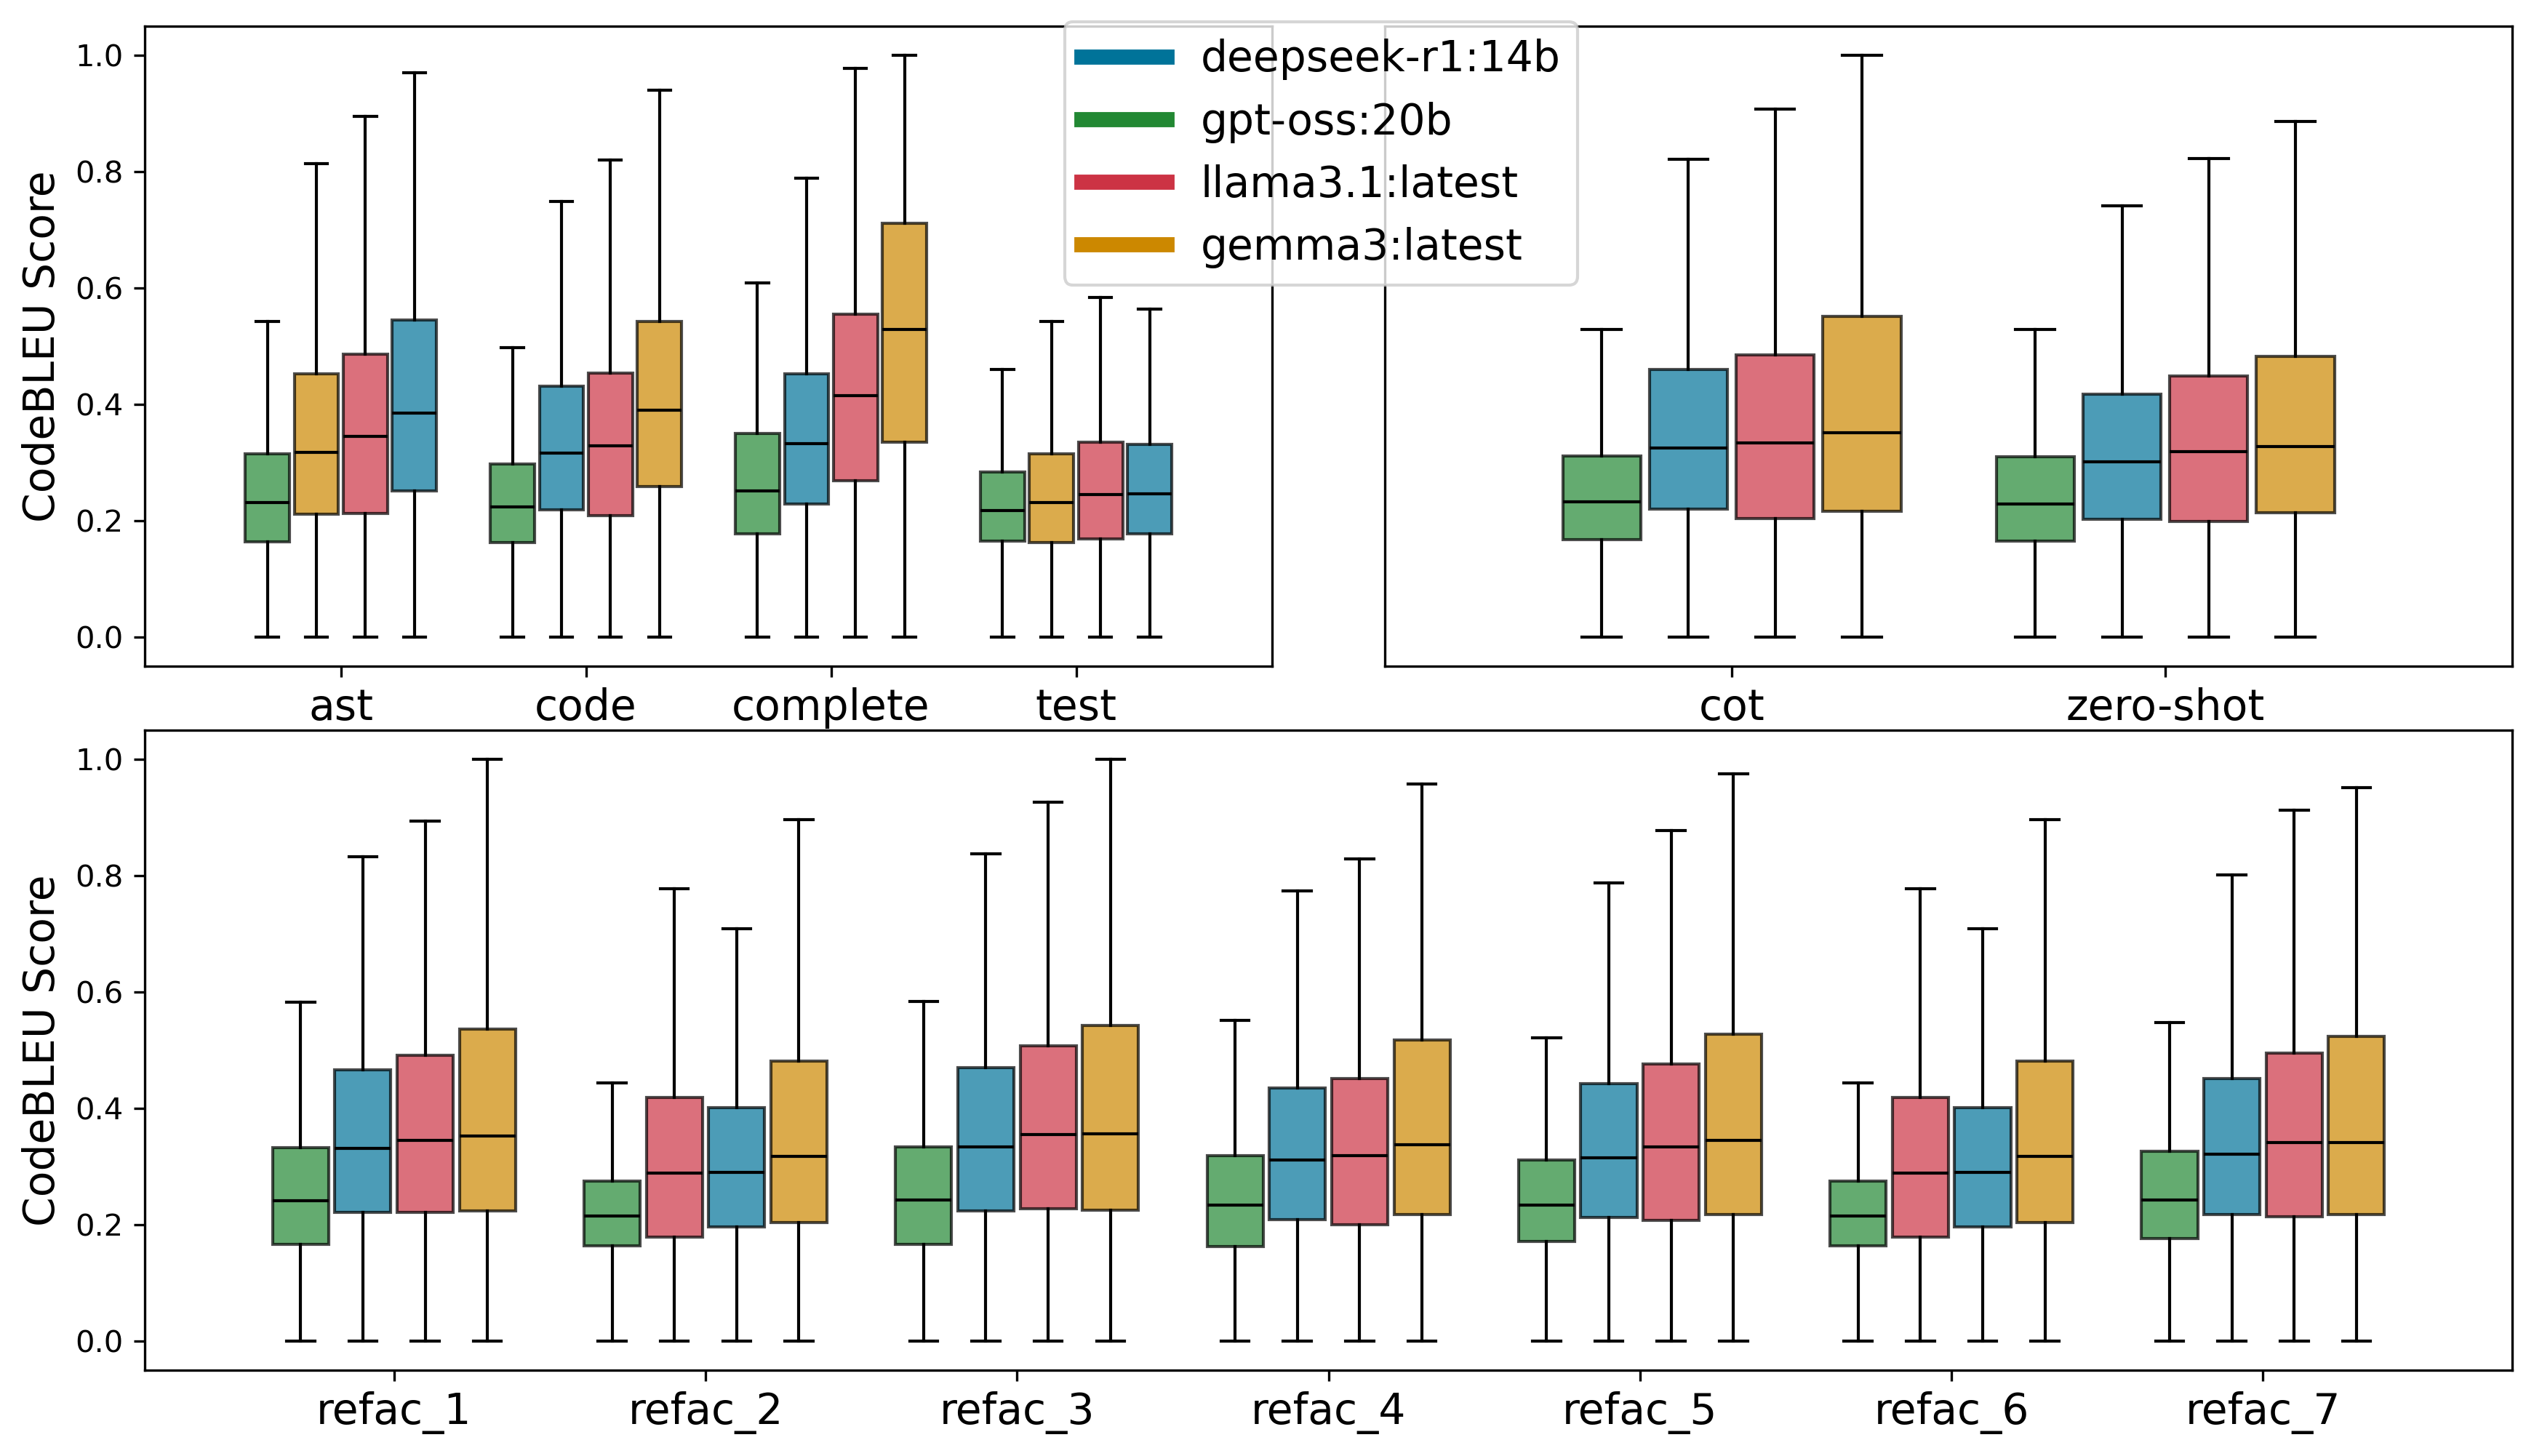

In [4]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

with open(OUT_PATH, "r", encoding="utf-8") as f:
    dataset = json.load(f)

scores_by_model = {}
for entry in dataset:
    for clone in entry.get("clones", []):
        if clone.get("code") == "None":  # skip invalid entries
            continue

        model = clone.get("model", "unknown")
        context = clone.get("context", "unknown")
        strategy = clone.get("strategy", "unknown")
        score_dict = clone.get("metrics", {}).get("codebleu", {})
        score = score_dict.get("originalcode")

        if score is not None:
            model_dict = scores_by_model.setdefault(model, {"context": {}, "strategy": {}, "refacs": {}})
            model_dict["context"].setdefault(context, []).append(score)
            model_dict["strategy"].setdefault(strategy, []).append(score)

            refacs = clone.get("refacs", [])
            if isinstance(refacs, list):
                for ref in refacs:
                    model_dict["refacs"].setdefault(ref, []).append(score)
            elif isinstance(refacs, str):
                model_dict["refacs"].setdefault(refacs, []).append(score)

categories = ["context", "strategy", "refacs"]
fig = plt.figure(figsize=(14, 8), dpi=300)


gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.1, wspace=0.1)
axes = [fig.add_subplot(gs[0, 0]),  # context
        fig.add_subplot(gs[0, 1]),  # strategy
        fig.add_subplot(gs[1, :])]  # refacs spanning both columns

for ax, cat in zip(axes, categories):
    labels = set()
    for grouped in scores_by_model.values():
        labels.update(grouped[cat].keys())
    labels = sorted(labels)
    num_labels = len(labels)

    for i, label in enumerate(labels):
        # Compute median for each model for this label
        model_scores = []
        for model, grouped in scores_by_model.items():
            scores = grouped[cat].get(label, [])
            if scores:
                model_scores.append((model, scores, np.median(scores)))

        # Sort models by median ascending
        model_scores = sorted(model_scores, key=lambda x: x[2])

        for j, (model, scores, _) in enumerate(model_scores):
            pos = i - 0.4 + (j + 0.5) * (0.8 / len(model_scores))
            bp = ax.boxplot(
                scores, positions=[pos], widths=0.8 / len(model_scores) * 0.9,
                patch_artist=True, medianprops=dict(color="black"), showfliers=False
            )
            for patch in bp['boxes']:
                patch.set_facecolor(MODEL_COLORS.get(model, "#333333"))
                patch.set_alpha(0.7)


    ax.set_xticks(np.arange(num_labels))
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel("CodeBLEU Score", fontsize=14)


axes[1].get_yaxis().set_visible(False)

# Floating legend between first two subplots
legend_ax = fig.add_axes([0.46, 0.757, 0.1, 0.1])  # [left, bottom, width, height] in figure coords
legend_ax.axis('off')
handles = [plt.Line2D([0], [0], color=color, lw=5) for color in MODEL_COLORS.values()]
labels = list(MODEL_COLORS.keys())
legend_ax.legend(handles, labels, loc='center', fontsize=14,  ncol=1)

plt.tight_layout()
pdf_path = os.path.join(PLOT_RESULTS, "RQ1codebleuResults.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show()


### Tests

C:\Users\lamp6\AppData\Local\Temp\ipykernel_29056\4058330818.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


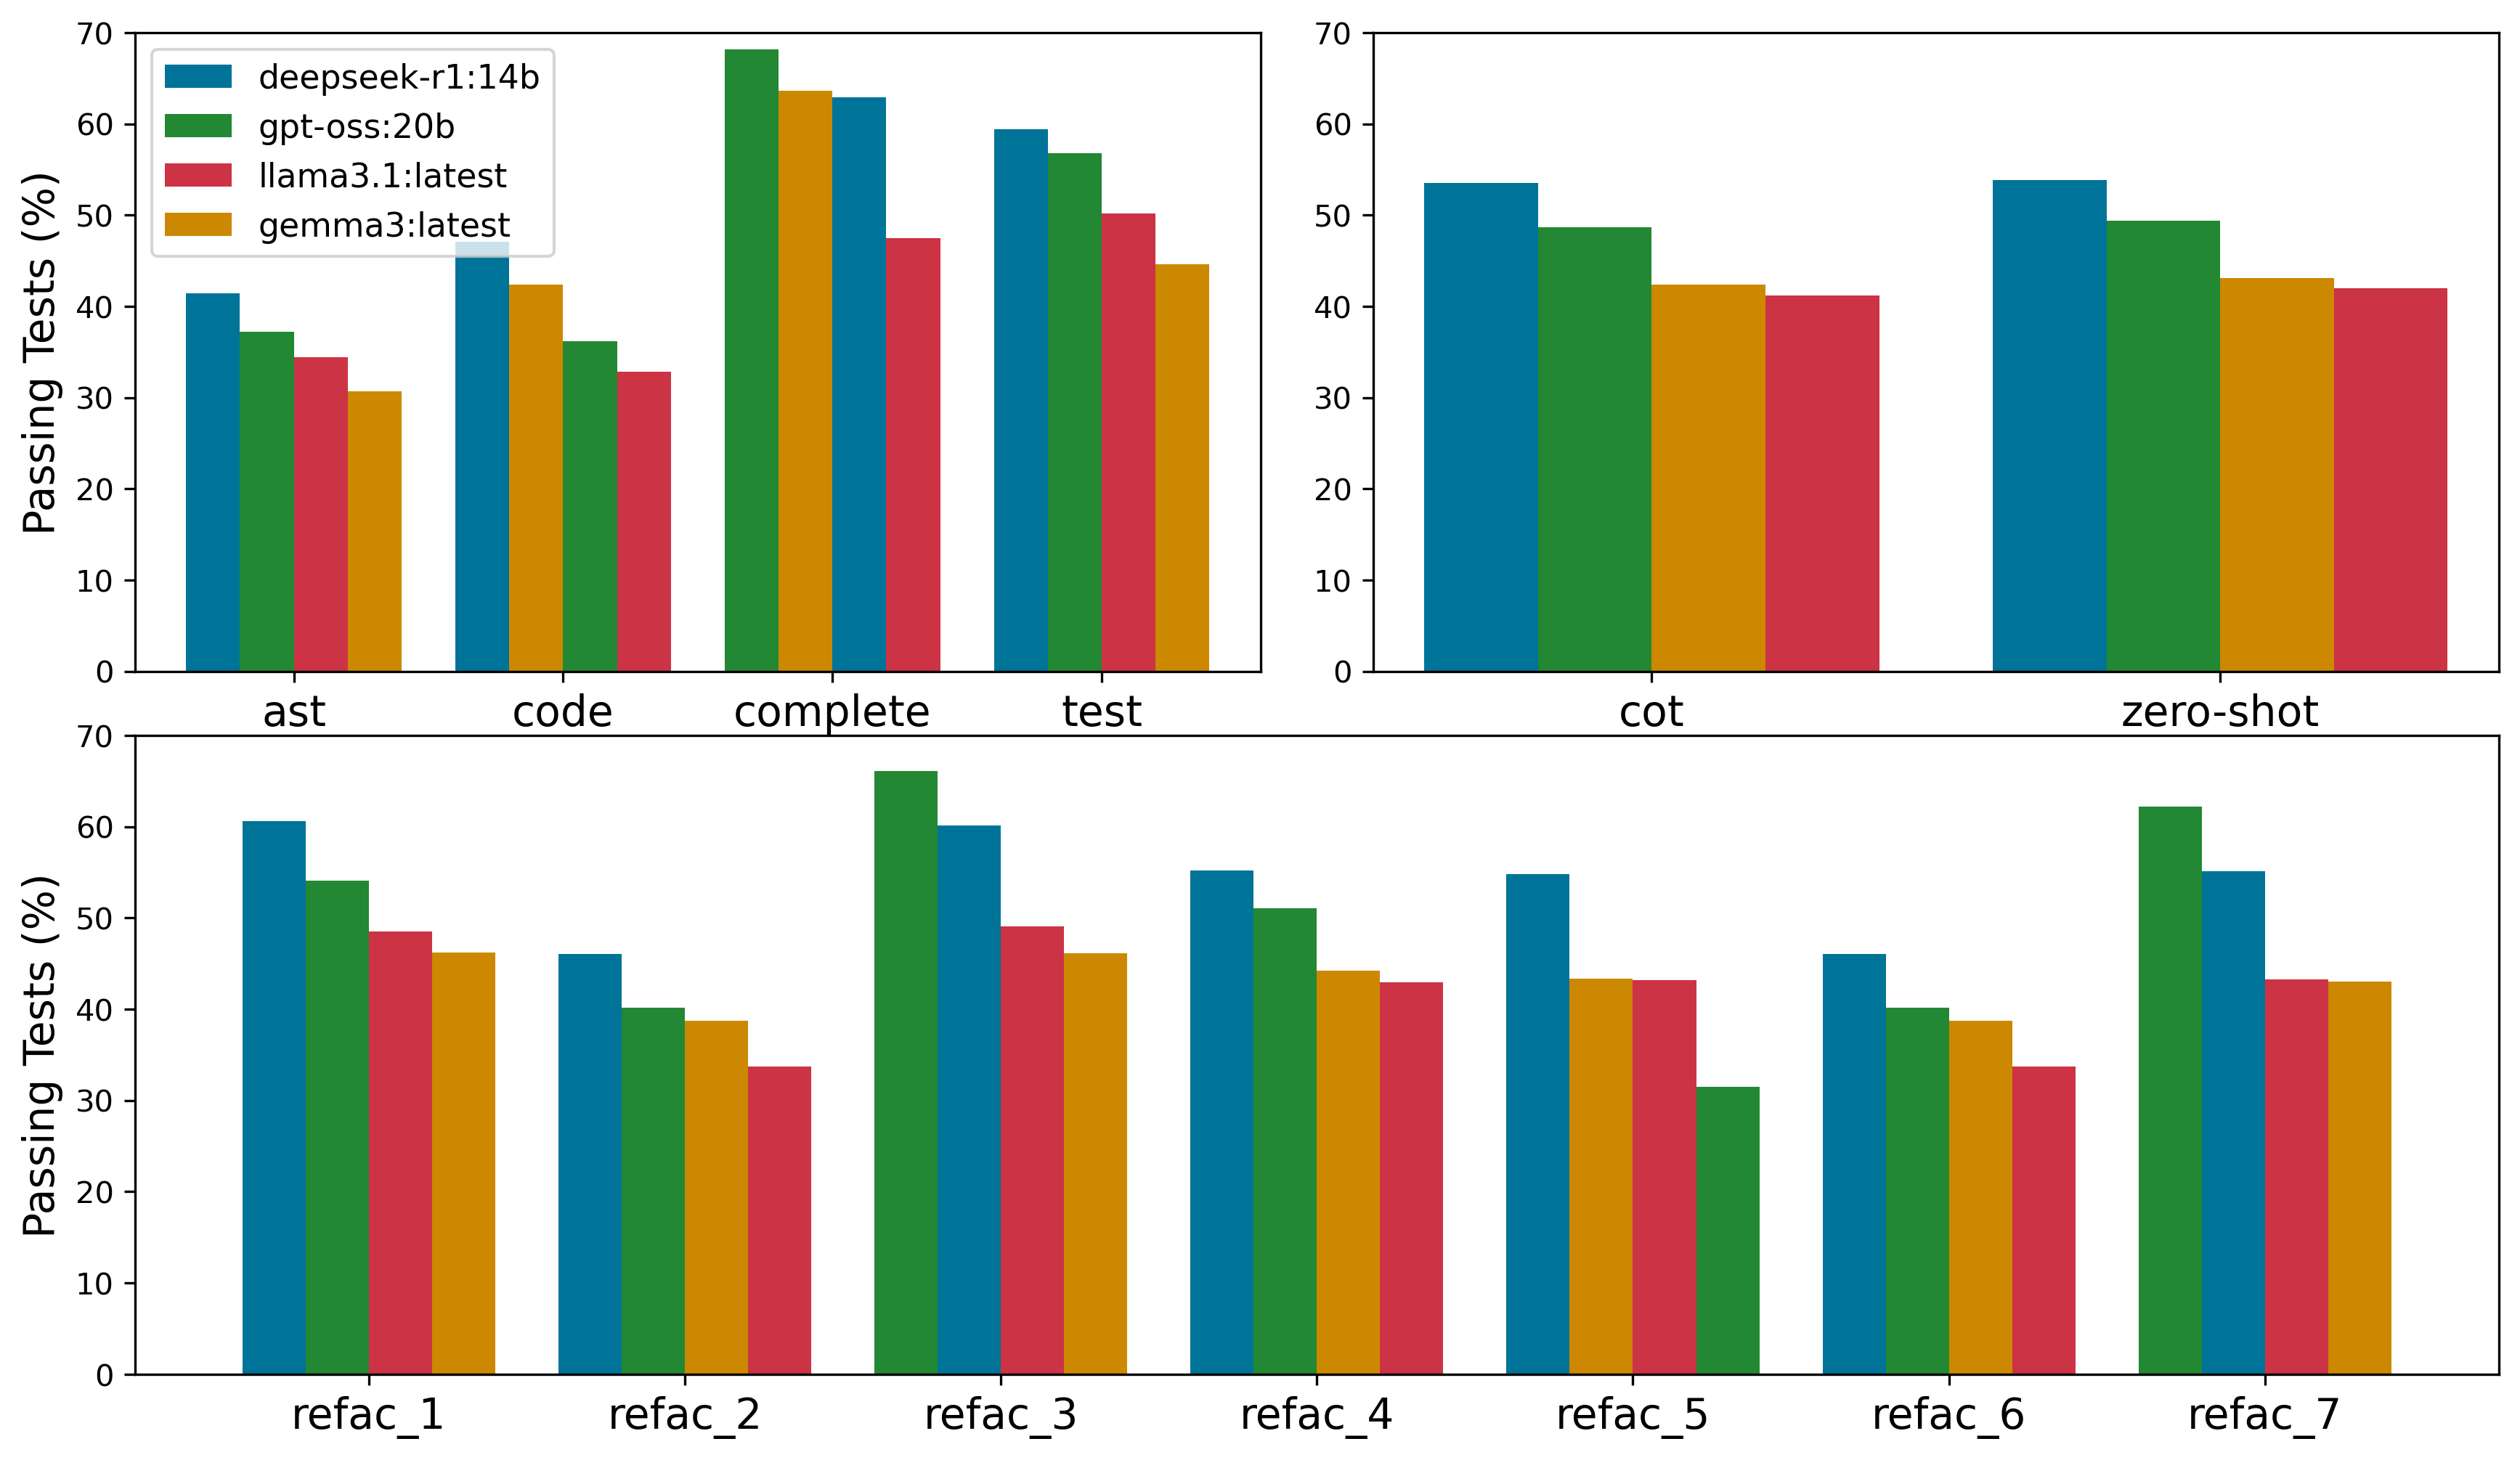

In [5]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os 
 
with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Identify all models
models = sorted({clone.get("model", "unknown") for entry in dataset for clone in entry.get("clones", [])})

#  Group test results per model 
grouped_by_context = {}
grouped_by_strategy = {}
grouped_by_refacs = {}

for entry in dataset:
    if not entry.get("clones"):
        continue
    num_tests = max(len(clone.get("test_results", {})) for clone in entry["clones"])
    
    for clone in entry.get("clones", []):
        model = clone.get("model", "unknown")
        context = clone.get("context", "unknown")
        strategy = clone.get("strategy", "unknown")
        refacs_list = clone.get("refacs", ["unknown"])
        results = clone.get("test_results", {})

        # Fill missing tests as ERROR
        if len(results) < num_tests:
            for i in range(num_tests - len(results)):
                results[f"missing_test_{i+1}"] = "ERROR"

        # Initialize dicts
        grouped_by_context.setdefault(context, {})
        grouped_by_strategy.setdefault(strategy, {})
        for refac in refacs_list:
            grouped_by_refacs.setdefault(refac, {})

        # Count PASS / TOTAL per model
        def update_group(group, key):
            group[key].setdefault(model, {"PASS": 0, "TOTAL": 0})
            for status in results.values():
                group[key][model]["TOTAL"] += 1
                if status.upper() == "PASS":
                    group[key][model]["PASS"] += 1

        update_group(grouped_by_context, context)
        update_group(grouped_by_strategy, strategy)
        for refac in refacs_list:
            update_group(grouped_by_refacs, refac)

def prepare_percent_data(grouped_dict):
    labels = sorted(grouped_dict.keys())
    percentages = {model: [] for model in models}
    for label in labels:
        for model in models:
            data = grouped_dict[label].get(model, {"PASS": 0, "TOTAL": 0})
            pct = data["PASS"]/data["TOTAL"]*100 if data["TOTAL"] > 0 else 0
            percentages[model].append(pct)
    return labels, percentages

filters_context, pct_context = prepare_percent_data(grouped_by_context)
filters_strategy, pct_strategy = prepare_percent_data(grouped_by_strategy)
filters_refacs, pct_refacs = prepare_percent_data(grouped_by_refacs)

fig = plt.figure(figsize=(14, 8), dpi=300)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.1, wspace=0.1)
axes = [fig.add_subplot(gs[0, 0]),  # context
        fig.add_subplot(gs[0, 1]),  # strategy
        fig.add_subplot(gs[1, :])]  # refacs

def plot_grouped_bar(ax, labels, percentages_dict, title, show_ylabel=True):
    x = np.arange(len(labels))
    total_models = len(models)
    width = 0.8 / total_models

    for i, label in enumerate(labels): 
        model_pcts = [(model, percentages_dict[model][i]) for model in models] 
        model_pcts_sorted = sorted(model_pcts, key=lambda x: x[1], reverse=True) 
        for j, (model, pct) in enumerate(model_pcts_sorted):
            ax.bar(
                i - 0.4 + (j + 0.5) * width, 
                pct, 
                width=width, 
                color=MODEL_COLORS.get(model, "#333333"),
                label=model if i == 0 else ""  
            )

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=14)
    if show_ylabel:
        ax.set_ylabel("Passing Tests (%)", fontsize=14)
    ax.set_ylim(0, 70)
    ax.set_title(title)
    

# Plot panels
plot_grouped_bar(axes[0], filters_context, pct_context, "")
plot_grouped_bar(axes[1], filters_strategy, pct_strategy, "", show_ylabel=False)
plot_grouped_bar(axes[2], filters_refacs, pct_refacs, "")

# Legend centered between top row
handles, labels_legend = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels_legend, title="", loc='upper left', fontsize=11)
plt.tight_layout()

pdf_path = os.path.join(PLOT_RESULTS, "RQ1testResults.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show()


### Reprompt

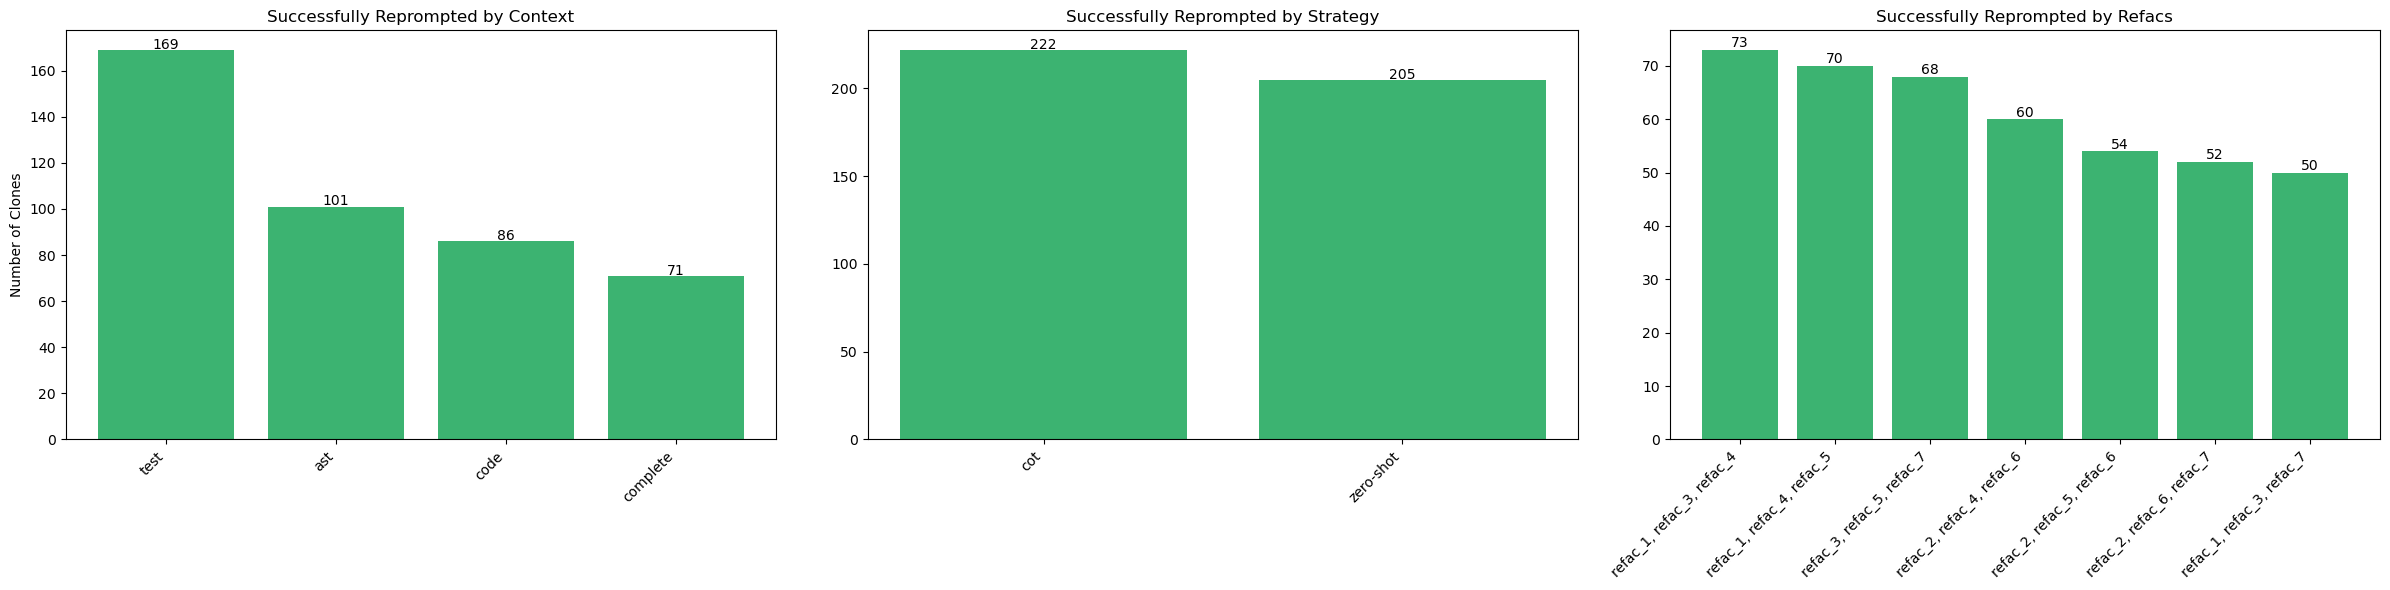

In [10]:
import json
import matplotlib.pyplot as plt

with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    before_data = json.load(f)

with open(REPROMPT_PATH, "r", encoding="utf-8") as f:
    after_data = json.load(f)

#  Index clones
def index_clones(dataset):
    index = {}
    for entry in dataset:
        entry_id = entry.get("id")
        for clone in entry.get("clones", []):
            clone_id = clone.get("clone_id")
            index[(entry_id, clone_id)] = clone
    return index

before_index = index_clones(before_data)
after_index = index_clones(after_data)
categories = ["Successfully Reprompted"]
grouped_context = {}
grouped_refacs = {}
grouped_strategy = {}

for key, before_clone in before_index.items():
    after_clone = after_index.get(key)
    if not after_clone:
        continue  # skip clones not reprompted

    before_results = before_clone.get("test_results", {})
    after_results  = after_clone.get("test_results", {})

    # Count number of passing tests
    before_pass = sum(1 for r in before_results.values() if isinstance(r, str) and r.upper() == "PASS")
    after_pass  = sum(1 for r in after_results.values()  if isinstance(r, str) and r.upper() == "PASS")

    improved = after_pass > before_pass
    if not improved:
        continue  # only count successfully reprompted clones

    context = after_clone.get("context", "unknown")
    strategy = after_clone.get("strategy", "unknown")
    refacs_list = after_clone.get("refacs", ["unknown"])
    refacs_key = ", ".join(refacs_list)

    # Group by context
    grouped_context[context] = grouped_context.get(context, 0) + 1
    # Group by strategy
    grouped_strategy[strategy] = grouped_strategy.get(strategy, 0) + 1
    # Group by refacs
    grouped_refacs[refacs_key] = grouped_refacs.get(refacs_key, 0) + 1

#  Plotting function with descending order 
def plot_grouped(ax, grouped_dict, title):
    # Sort descending
    sorted_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    filters, values = zip(*sorted_items) if sorted_items else ([], [])

    x = range(len(filters))
    ax.bar(x, values, color="mediumseagreen")
    ax.set_xticks(x)
    ax.set_xticklabels(filters, rotation=45, ha="right", fontsize=10)
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha="center", fontsize=10)

#  Create subplots 
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

plot_grouped(axes[0], grouped_context, "Successfully Reprompted by Context")
plot_grouped(axes[1], grouped_strategy, "Successfully Reprompted by Strategy")
plot_grouped(axes[2], grouped_refacs, "Successfully Reprompted by Refacs")

axes[0].set_ylabel("Number of Clones")
plt.tight_layout()
plt.show()


### Clustering

The code below generates ```.py``` files on ```CLUSTER_DIR``` for visualization.

In [15]:
from src.steps.clustering import process_clusters_for_entry
import json, warnings
warnings.filterwarnings("ignore")
with open(FILTERED_PATH_TESTS, "r", encoding="utf-8") as f:
    data = json.load(f)
process_clusters_for_entry(entry=data[0],clusters_dir=CLUSTER_DIR,representatives_json=FINAL_DATASET)

Saved cluster 0 for BigCodeBench/12 -> ../results/RQ1/clustering\clusters\BigCodeBench_12\cluster_0.py
Saved representatives for BigCodeBench/12 -> ../results/RQ1/clustering\clusters\BigCodeBench_12\representatives\BigCodeBench_12_representatives.py


In [6]:
import pandas as pd

df = pd.read_csv(f"{CLUSTER_DIR}/all_clusters.csv")

# Parse clone_ids into a list
df["clone_list"] = df["clone_ids"].apply(lambda x: x.split(";") if pd.notna(x) else [])

# Compute statistics
clones_per_cluster = df.groupby("cluster_id")["num_clones"].sum()
stats = {
    "total_entries": len(df),
    "total_clusters": df["cluster_id"].nunique(),
    "total_clones": df["num_clones"].sum(),
    "avg_clones_per_cluster": clones_per_cluster.mean(),
    "std_clones_per_cluster": clones_per_cluster.std(), 
    "min_clones_per_cluster": clones_per_cluster.min(),
    "max_clones_per_cluster": clones_per_cluster.max()
}

print("=== Cluster Statistics ===")
for k, v in stats.items():
    print(f"{k}: {v}")



=== Cluster Statistics ===
total_entries: 6852
total_clusters: 42
total_clones: 30573
avg_clones_per_cluster: 727.9285714285714
std_clones_per_cluster: 1084.5373385347125
min_clones_per_cluster: 1
max_clones_per_cluster: 4190


### Efficiency

C:\Users\lamp6\AppData\Local\Temp\ipykernel_18976\752162783.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([smart_capitalize(label) for label in ax.get_yticklabels()], fontsize=15)


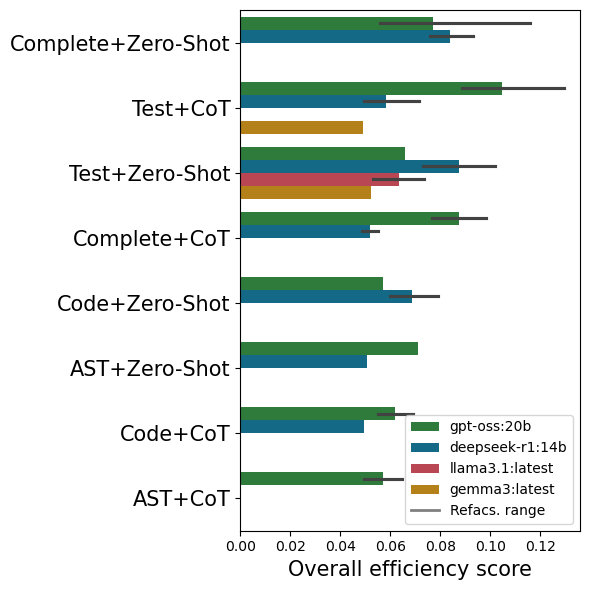

In [3]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

df = pd.read_csv(EFFICIENCY_PATH)

df_top = df.sort_values(by="efficiency", ascending=False).head(TOP_N)

df_top["config"] = df_top["context"] + "+" + df_top["strategy"]

plt.figure(figsize=(6, 6))

ax = sns.barplot(
    data=df_top,
    x="efficiency",
    y="config",
    hue="model",
    palette=MODEL_COLORS
)

plt.xlabel("Overall efficiency score", fontsize=15)
plt.ylabel("")

# Custom capitalization: title case + preserve "AST" and "CoT"
def smart_capitalize(label):
    text = label.get_text().title()
    text = text.replace("Ast", "AST").replace("Cot", "CoT")
    return text

ax.set_yticklabels([smart_capitalize(label) for label in ax.get_yticklabels()], fontsize=15)

# Legend setup (same as before)
gray_line = Line2D([0], [0], color='gray', lw=2, label='Range across refacs.')
handles, labels = ax.get_legend_handles_labels()
handles.append(gray_line)
labels.append('Refacs. range')
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=10)

plt.tight_layout()
pdf_path = os.path.join(PLOT_RESULTS, "RQ1efficiencyResults.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show()


Analyzing how each factor individually affects clone survival...


,model,efficiency
0,deepseek-r1:14b,0.052550
2,gpt-oss:20b,0.039037
3,llama3.1:latest,0.022758
1,gemma3:latest,0.017926


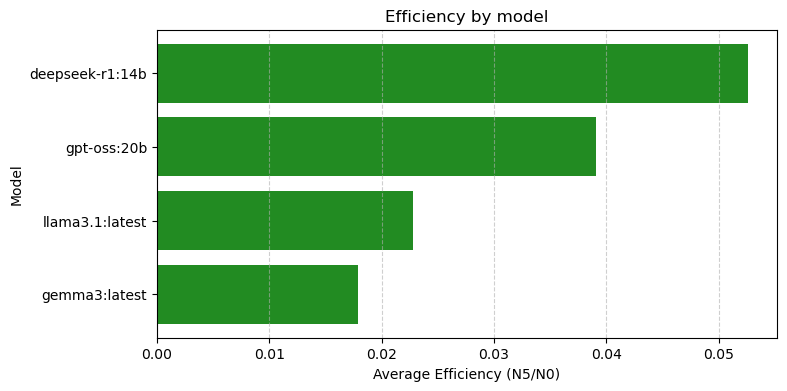

,context,efficiency
3,test,0.044909
2,complete,0.039867
1,code,0.029001
0,ast,0.018494


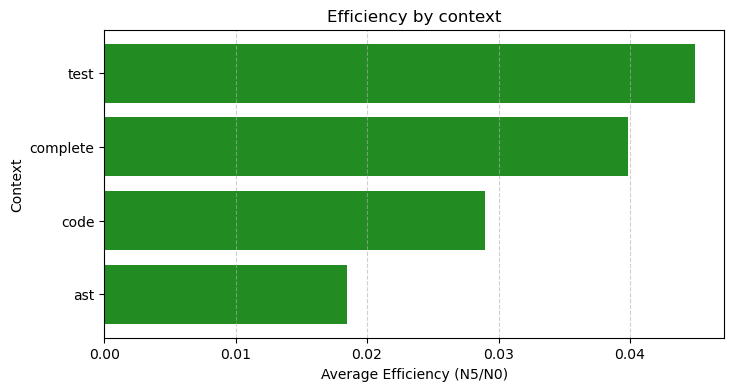

,refac,efficiency
0,"refac_1,refac_3,refac_4",0.043218
2,"refac_1,refac_4,refac_5",0.041085
1,"refac_1,refac_3,refac_7",0.030563
5,"refac_2,refac_6,refac_7",0.030179
6,"refac_3,refac_5,refac_7",0.029797
4,"refac_2,refac_5,refac_6",0.029695
3,"refac_2,refac_4,refac_6",0.026937


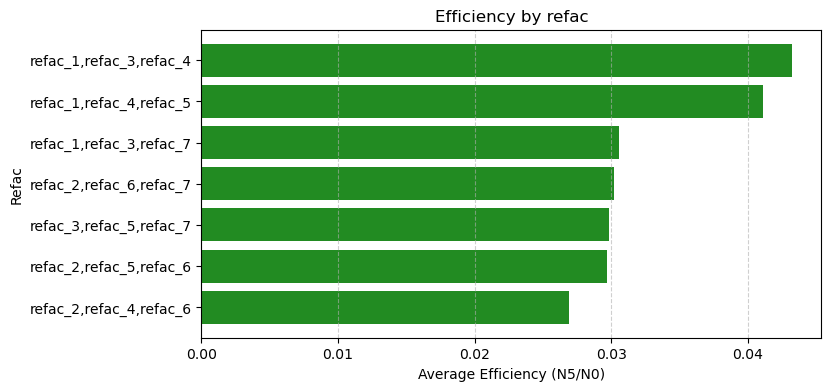

,strategy,efficiency
1,zero-shot,0.038282
0,cot,0.027854


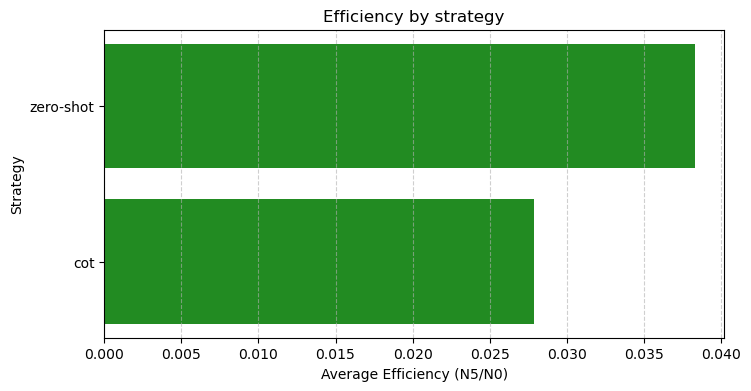

 Saved: ../results/RQ1/plots/efficiency_by_model.csv
 Saved: ../results/RQ1/plots/efficiency_by_context.csv
 Saved: ../results/RQ1/plots/efficiency_by_refac.csv
 Saved: ../results/RQ1/plots/efficiency_by_strategy.csv


In [4]:
import os
import matplotlib.pyplot as plt
from src.config import *
from src.utils.efficiency import _load_clones, _count_stage

print("Analyzing how each factor individually affects clone survival...")

# Load first (0) and last (5) clone stages
df0 = _load_clones(OUT_PATH)
df5 = _load_clones(FINAL_DATASET)

# Count number of clones per configuration
counts_0 = _count_stage(df0, "0")
counts_5 = _count_stage(df5, "5")

# Merge and compute efficiency (survival rate)
df = counts_0.merge(counts_5, on=["model", "context", "refac", "strategy"], how="left").fillna(0)
df["efficiency"] = df.apply(lambda x: x["N_5"] / x["N_0"] if x["N_0"] > 0 else 0, axis=1)

# Factors to analyze
factors = ["model", "context", "refac", "strategy"]

results = {}

for factor in factors:
    grouped = df.groupby(factor)["efficiency"].mean().reset_index().sort_values(by="efficiency", ascending=False)
    results[factor] = grouped 
    display(grouped)

    # Plot each factor
    plt.figure(figsize=(8,4))
    plt.barh(grouped[factor], grouped["efficiency"], color="forestgreen")
    plt.xlabel("Average Efficiency (N5/N0)")
    plt.ylabel(factor.capitalize())
    plt.title(f"Efficiency by {factor}")
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()


os.makedirs(PLOT_RESULTS, exist_ok=True)
for factor, df_factor in results.items():
    output_path = os.path.join(PLOT_RESULTS, f"efficiency_by_{factor}.csv")
    df_factor.to_csv(output_path, index=False)
    print(f" Saved: {output_path}")


### Missing entries

In [5]:
import json 
with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    data1 = json.load(f)

with open(FINAL_DATASET, "r", encoding="utf-8") as f:
    data2 = json.load(f)

#  Extract the IDs 
ids1 = {item["id"] for item in data1}
ids2 = {item["id"] for item in data2}

#  Find missing IDs 
missing_ids = ids1 - ids2

if missing_ids:
    print(f"{len(missing_ids)} entries missing in final dataset:\n")
    for item in data1:
        if item["id"] in missing_ids:
            clones = item.get("clones", [])
            total_tests = 0
            if clones:
                first_clone = clones[0]
                test_results = first_clone.get("test_results", {})
                total_tests = len(test_results)
            print(f"{item['id']} - total tests: {total_tests}")
else:
    print("All entries from the first dataset are present in the second.")

70 entries missing in final dataset:

BigCodeBench/36 - total tests: 6
BigCodeBench/59 - total tests: 12
BigCodeBench/80 - total tests: 6
BigCodeBench/81 - total tests: 5
BigCodeBench/83 - total tests: 5
BigCodeBench/91 - total tests: 6
BigCodeBench/121 - total tests: 5
BigCodeBench/126 - total tests: 5
BigCodeBench/169 - total tests: 7
BigCodeBench/190 - total tests: 6
BigCodeBench/191 - total tests: 9
BigCodeBench/200 - total tests: 5
BigCodeBench/220 - total tests: 5
BigCodeBench/224 - total tests: 5
BigCodeBench/226 - total tests: 5
BigCodeBench/233 - total tests: 5
BigCodeBench/242 - total tests: 5
BigCodeBench/282 - total tests: 3
BigCodeBench/327 - total tests: 5
BigCodeBench/354 - total tests: 5
BigCodeBench/365 - total tests: 5
BigCodeBench/378 - total tests: 5
BigCodeBench/381 - total tests: 4
BigCodeBench/396 - total tests: 5
BigCodeBench/402 - total tests: 10
BigCodeBench/404 - total tests: 5
BigCodeBench/419 - total tests: 6
BigCodeBench/421 - total tests: 10
BigCodeBench/